In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import ML dependencies
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor



# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [83]:
# read dataframe
sleep_df = pd.read_csv("Sleep_Efficiency.csv")
sleep_df.head()

,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


In [84]:
sleep_df.describe()

,ID,Age,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Exercise frequency
count,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,452.000000,432.000000,427.000000,438.000000,446.000000
mean,226.500000,40.285398,7.465708,0.788916,22.615044,52.823009,24.561947,1.641204,23.653396,1.173516,1.791480
std,130.625419,13.172250,0.866625,0.135237,3.525963,15.654235,15.313665,1.356762,30.202785,1.621377,1.428134
min,1.000000,9.000000,5.000000,0.500000,15.000000,18.000000,7.000000,0.000000,0.000000,0.000000,0.000000
25%,113.750000,29.000000,7.000000,0.697500,20.000000,48.250000,15.000000,1.000000,0.000000,0.000000,0.000000
50%,226.500000,40.000000,7.500000,0.820000,22.000000,58.000000,18.000000,1.000000,25.000000,0.000000,2.000000
75%,339.250000,52.000000,8.000000,0.900000,25.000000,63.000000,32.500000,3.000000,50.000000,2.000000,3.000000
max,452.000000,69.000000,10.000000,0.990000,30.000000,75.000000,63.000000,4.000000,200.000000,5.000000,5.000000


In [85]:
sleep_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      452 non-null    int64  
 1   Age                     452 non-null    int64  
 2   Gender                  452 non-null    object 
 3   Bedtime                 452 non-null    object 
 4   Wakeup time             452 non-null    object 
 5   Sleep duration          452 non-null    float64
 6   Sleep efficiency        452 non-null    float64
 7   REM sleep percentage    452 non-null    int64  
 8   Deep sleep percentage   452 non-null    int64  
 9   Light sleep percentage  452 non-null    int64  
 10  Awakenings              432 non-null    float64
 11  Caffeine consumption    427 non-null    float64
 12  Alcohol consumption     438 non-null    float64
 13  Smoking status          452 non-null    object 
 14  Exercise frequency      446 non-null    fl

In [86]:
print("The shape of the dataframe is:\n")
print("rows:{}, columns:{}".format(sleep_df.shape[0], sleep_df.shape[1]))

The shape of the dataframe is:

rows:452, columns:15


In [87]:
# How many features are numeric and how many features are catagorical?
print("Numeric features are:\n")
print(list(sleep_df.select_dtypes(include="number").columns))

print("\n Catagorical features are:\n")
print(list(sleep_df.select_dtypes(exclude="number").columns))

Numeric features are:

['ID', 'Age', 'Sleep duration', 'Sleep efficiency', 'REM sleep percentage', 'Deep sleep percentage', 'Light sleep percentage', 'Awakenings', 'Caffeine consumption', 'Alcohol consumption', 'Exercise frequency']

 Catagorical features are:

['Gender', 'Bedtime', 'Wakeup time', 'Smoking status']


In [88]:
# Locate columns with null values
cols = sleep_df.columns[sleep_df.isnull().any()]

# fill null values
sleep_df[cols] = sleep_df[cols].fillna(sleep_df[cols].mode().iloc[0])

In [89]:
# Convert both Age and Gender to numerical values
sleep_no = sleep_df.replace({"Gender": {"Female": 0, "Male": 1}, "Smoking status": {"Yes": 0, "No":1}})

# Drop "ID" column as it should not have any relevance to other features
sleep_no.drop("ID", axis=1, inplace=True)
sleep_no.head()

,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency
0,65,0,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,0,3.0
1,69,1,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,0,3.0
2,40,0,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,1,3.0
3,40,0,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,0,1.0
4,57,1,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,1,3.0


# EDA

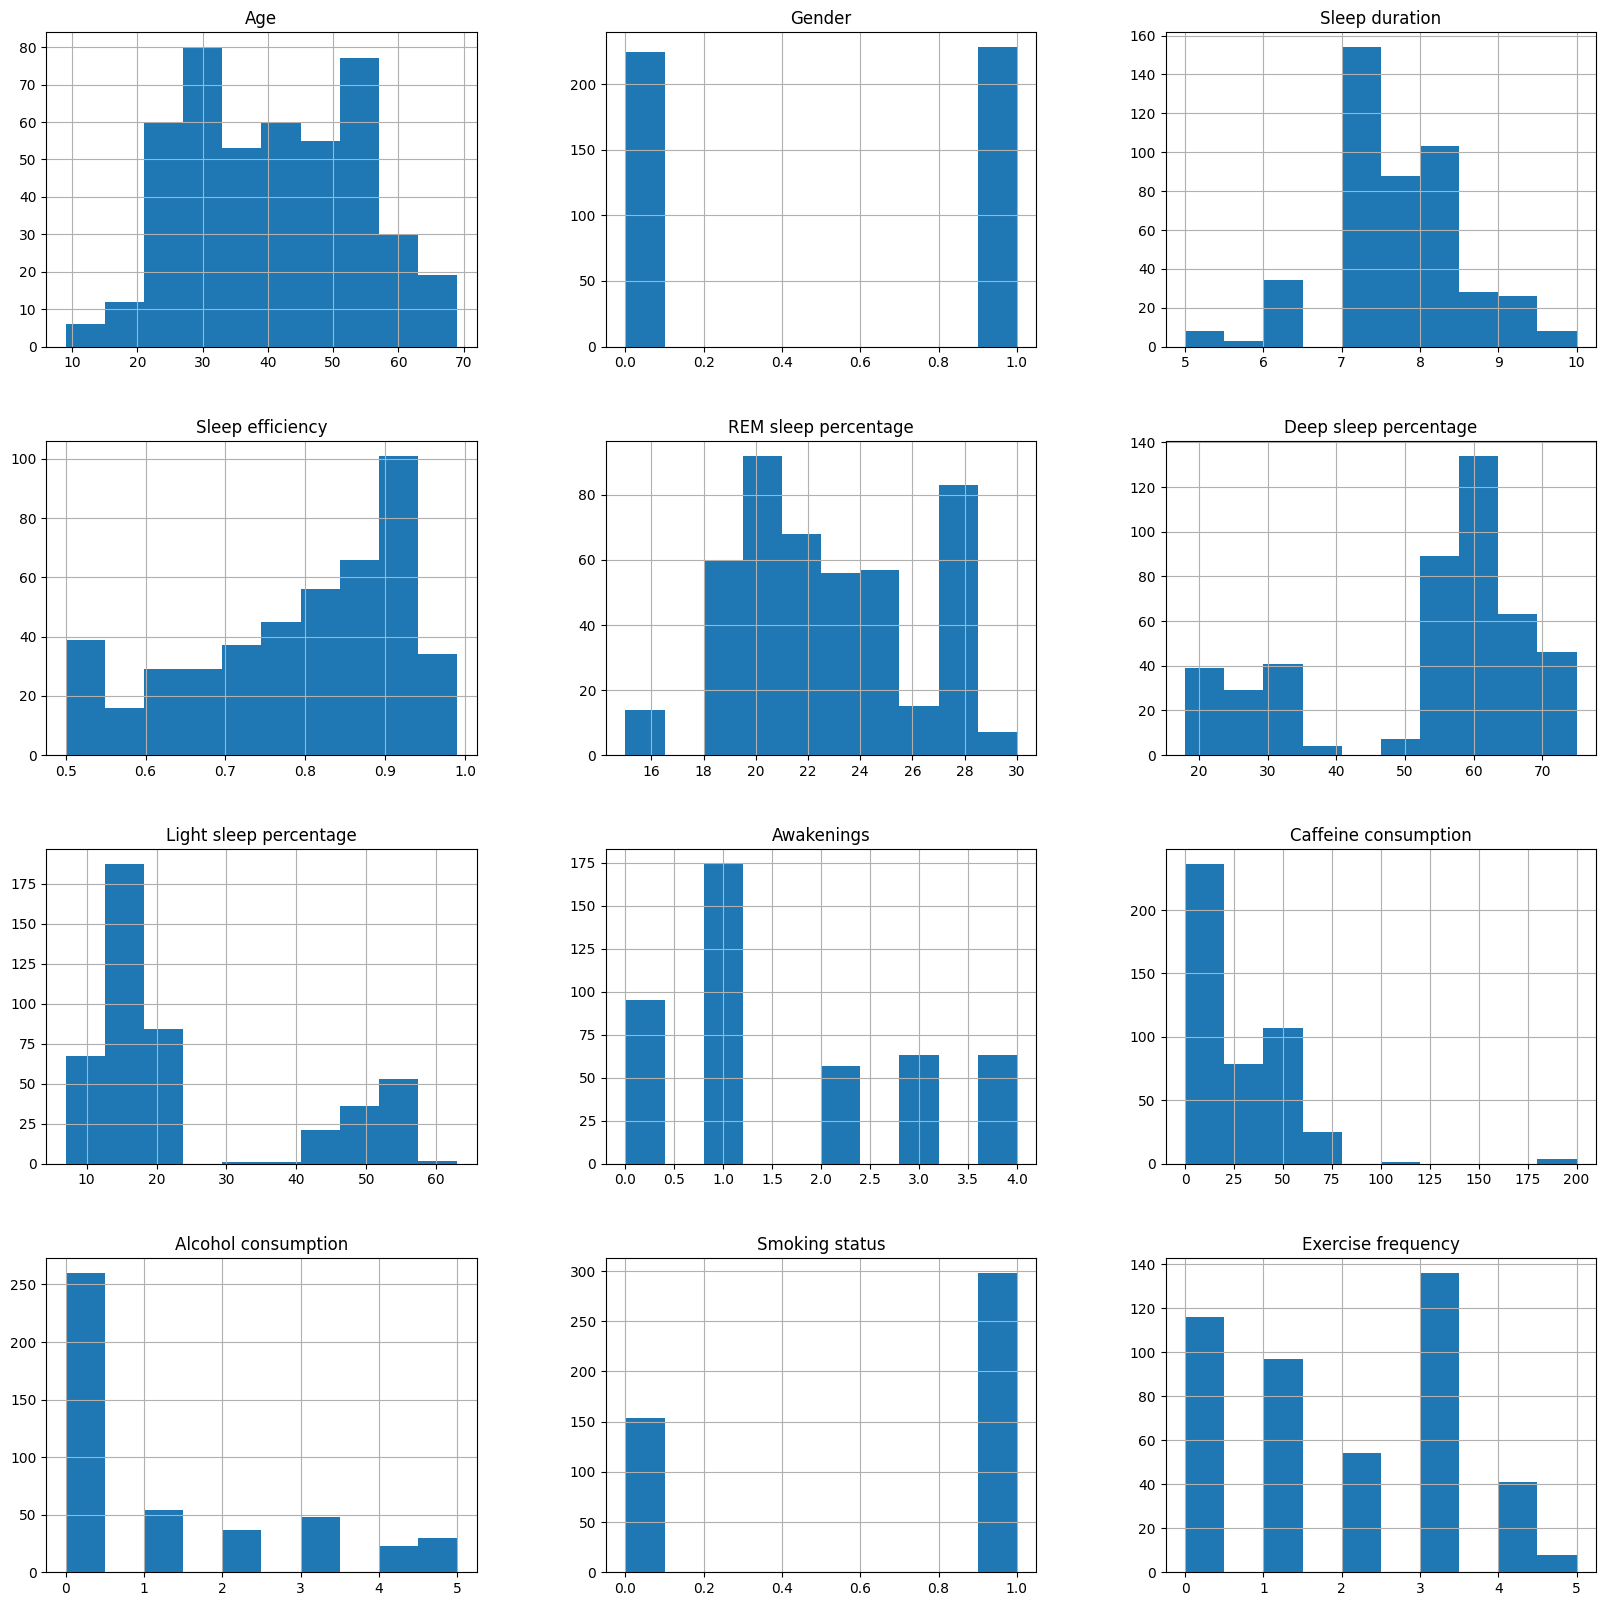

In [90]:
# Plot histgram to observe the distribution of the data
sleep_no.hist(figsize=(20,20))
plt.show()

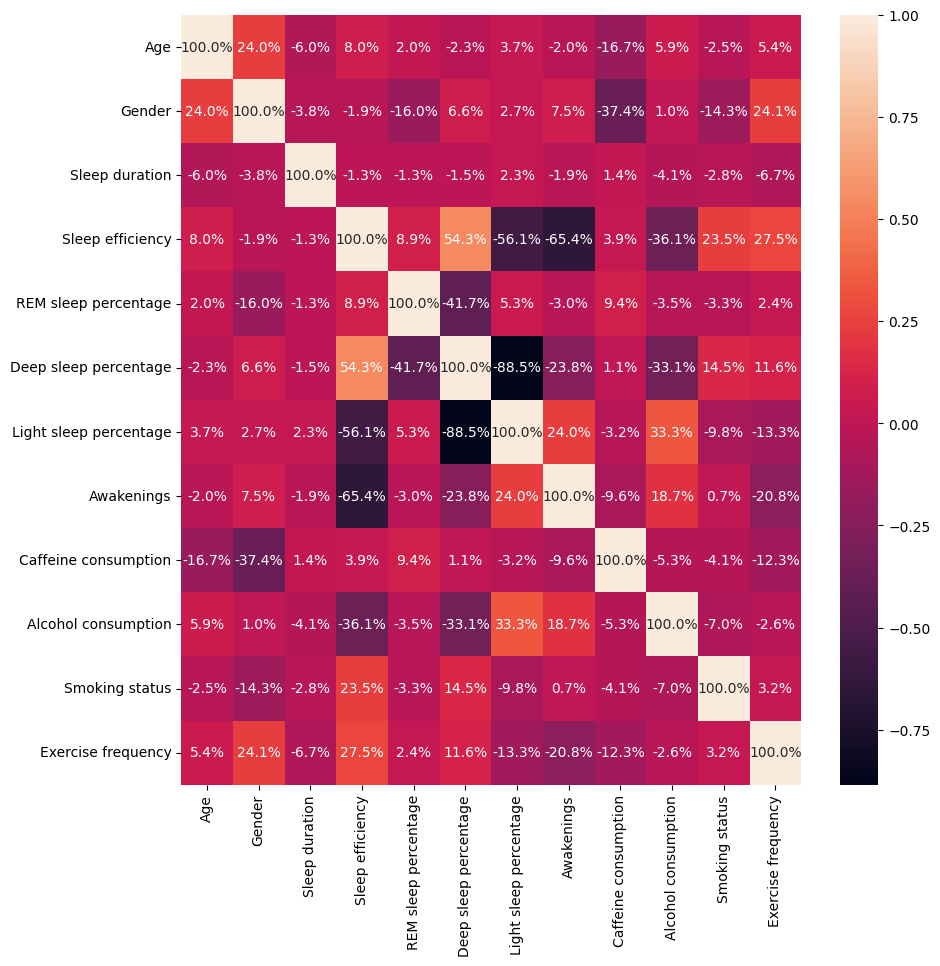

In [91]:
# Plot heatmap for spearman correlation
plt.figure(figsize=(10,10))
sns.heatmap(sleep_no.corr(method='spearman'), annot=True, fmt="0.1%")
plt.show()

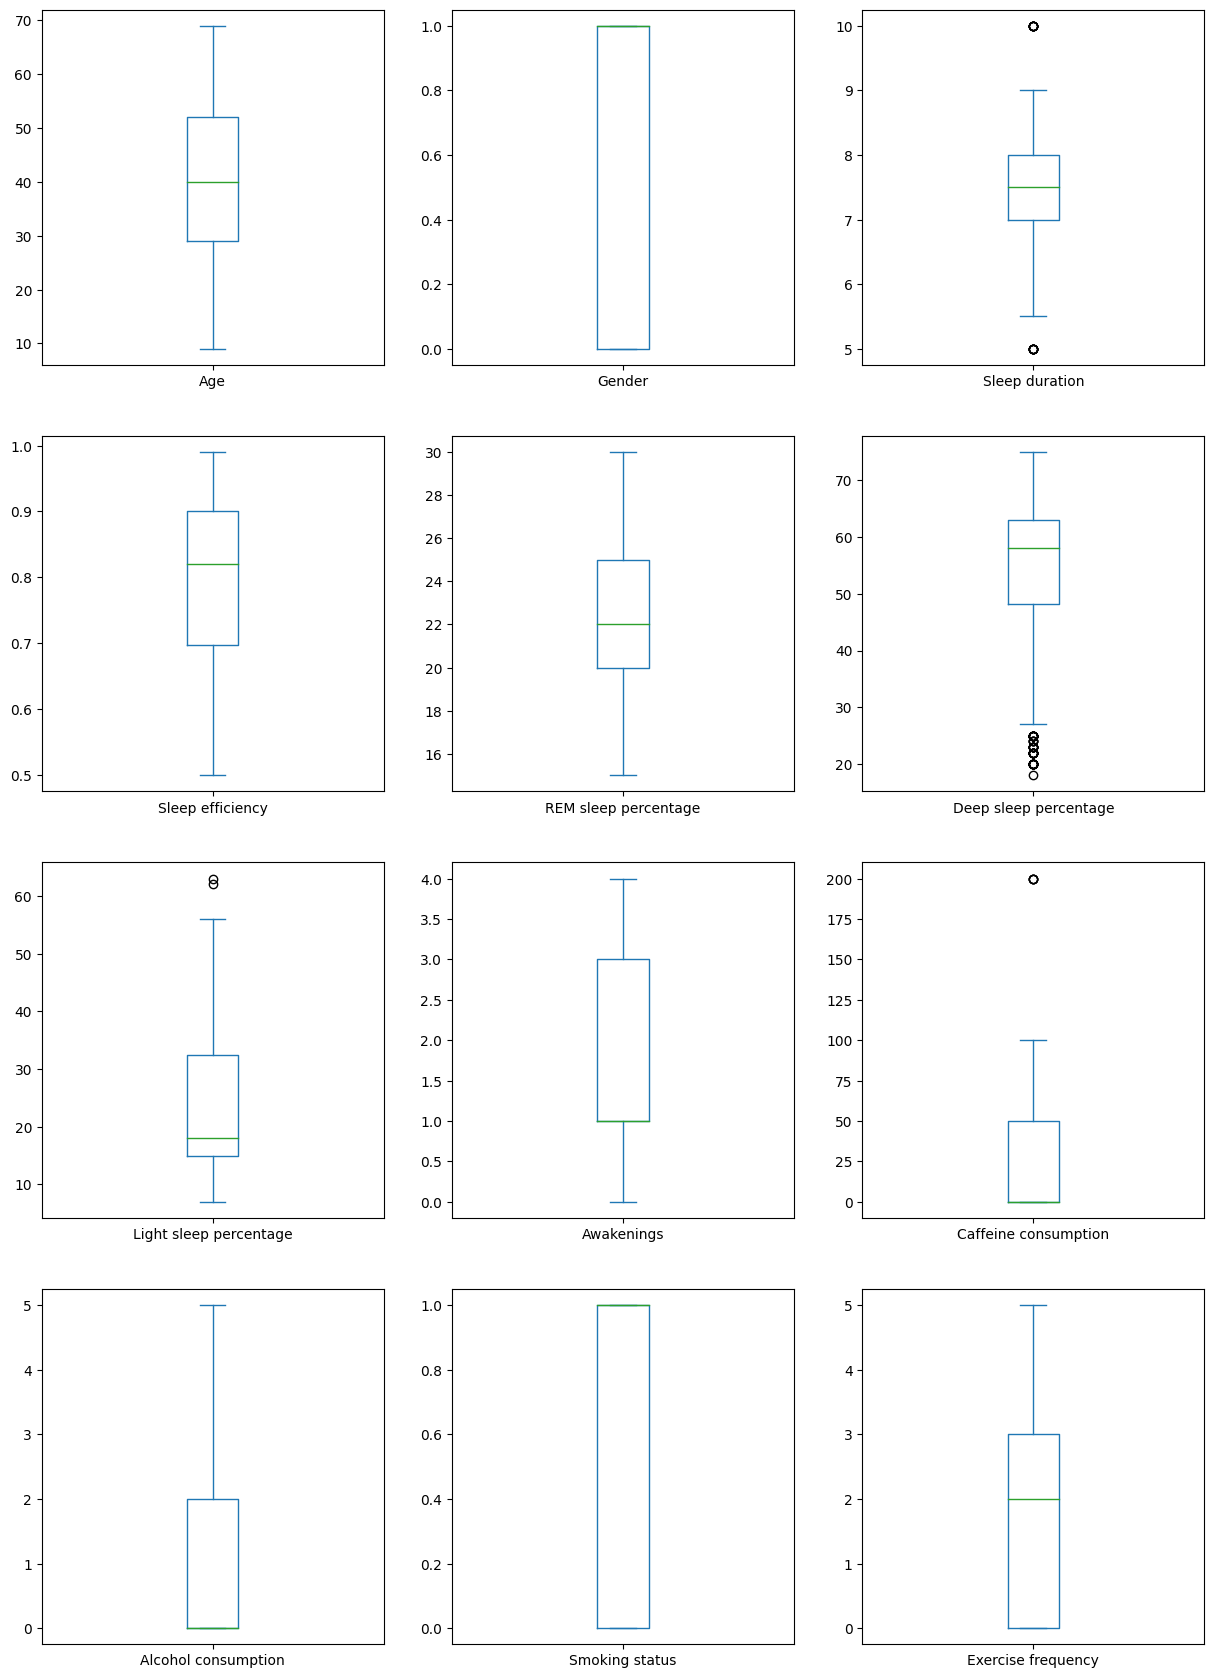

In [92]:
# Boxplot to see the distribution and outliers
sleep_no.plot(kind="box", subplots=True, layout=(11,3), sharex=False, sharey=False, figsize=(15,60))
plt.show()

In [93]:
# Remove outliers to reduce the possibilities of overfitting

new_sleep = sleep_no.copy()

# Capping outliers for column "Sleep duration"

duration_upper = new_sleep["Sleep duration"].mean()+ 3*new_sleep["Sleep duration"].std()
duration_lower = new_sleep["Sleep duration"].mean() - 3*new_sleep["Sleep duration"].std()
print("The highest allowed:", duration_upper)
print("The lowest allowed:", duration_lower)

new_sleep["Sleep duration"] = np.where(
    new_sleep["Sleep duration"]>duration_upper, duration_upper, np.where(
        new_sleep["Sleep duration"]<duration_lower, duration_lower, new_sleep["Sleep duration"])
    )



The highest allowed: 10.065582710459855
The lowest allowed: 4.865833218743685


In [94]:
# Capping outliers for column "Deep sleep percentage", it is a skewed distribution

QR25 = new_sleep["Deep sleep percentage"].quantile(0.25)
QR75 = new_sleep["Deep sleep percentage"].quantile(0.75)
IQR = QR75 - QR25
deep_upper = QR75 +1.5*IQR
deep_lower = QR25 - 1.5*IQR

print("The highest value is:", deep_upper)
print("The lowest value is:", deep_lower)

new_sleep["Deep sleep percentage"] = np.where(
    new_sleep["Deep sleep percentage"]>deep_upper, deep_upper,np.where(
        new_sleep["Deep sleep percentage"]<deep_lower, deep_lower, new_sleep["Deep sleep percentage"]
    ))

The highest value is: 85.125
The lowest value is: 26.125


In [95]:
# Capping outliers for column "Light sleep percentage", it is also a skewed distribution

QR25L = new_sleep["Light sleep percentage"].quantile(0.25)
QR75L = new_sleep["Light sleep percentage"].quantile(0.75)
IQRL = QR75L - QR25L
light_upper = QR75L +1.5*IQRL
light_lower = QR25L - 1.5*IQRL

print("The highest value is:", light_upper)
print("The lowest value is:", light_lower)

new_sleep["Light sleep percentage"] = np.where(
    new_sleep["Light sleep percentage"]>light_upper, light_upper,np.where(
        new_sleep["Light sleep percentage"]<light_lower, light_lower, new_sleep["Light sleep percentage"]
    ))

The highest value is: 58.75
The lowest value is: -11.25


# Machine Learning

In [96]:
# Define X and y
y = new_sleep["Sleep efficiency"]
X = new_sleep.drop(["Sleep efficiency", "Bedtime", "Wakeup time"], axis=1)

# Split train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [99]:
# ML by using XGBoost
XGBR = XGBRegressor()

# fit train sets
XGBR.fit(X_train_scaled, y_train)

# predit
y_pred = XGBR.predict(X_test_scaled)

# Evaluate predicted value and tested value
mae = mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:", mae)
r2 = r2_score(y_pred, y_test)
print("R2 Score:", r2)

Mean Absolute Error: 0.040395789094023644
R2 Score: 0.8062118693614286


From the above, the predictions are pretty good.

Text(0.5, 1.0, 'Feature Importance')

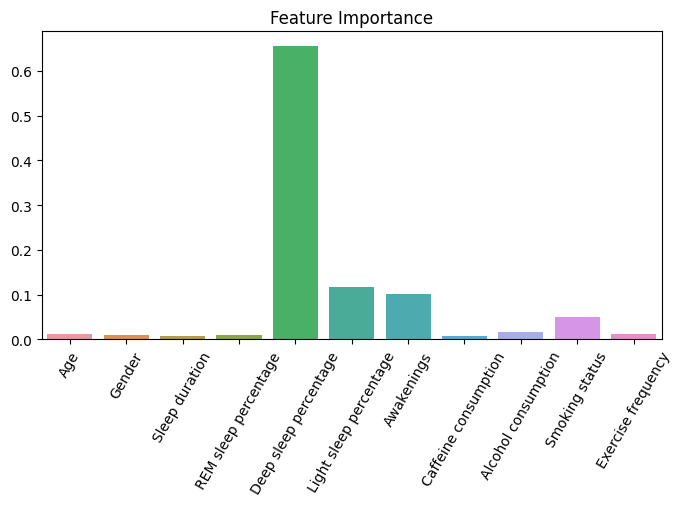

In [108]:
# Plot for feature importance
fig = plt.figure(figsize=(8,4))
sns.barplot(x=X.columns, y=XGBR.feature_importances_)
plt.xticks(rotation=60)
plt.title("Feature Importance")